In [1]:
import os
import torch
from model.faster_rcnn_vgg16 import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
from data.util import read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
%matplotlib inline

/datasets/home/home-00/06/206/j1burke/ECE285/ECE285_Sauvage_Object_Detection/model/utils/nms/non_maximum_suppression.py:12: UserWarning: 
    the python code for non_maximum_suppression is about 2x slow
    It is strongly recommended to build cython code: 
    `cd model/utils/nms/; python3 build.py build_ext --inplace
  `cd model/utils/nms/; python3 build.py build_ext --inplace''')


In [2]:
img = read_image('RCNN/dog-cycle-car.png')
img = torch.from_numpy(img)[None]
model_dir = 'model/'

In [3]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/opt/conda/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chun

Exception in user code:
------------------------------------------------------------


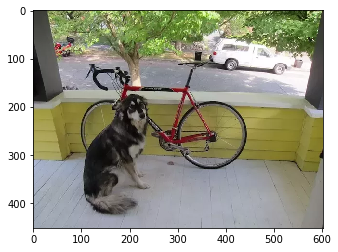

In [4]:
bboxes, labels, scores = trainer.faster_rcnn.predict(img,visualize=True)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(bboxes[0]),
         at.tonumpy(labels[0]).reshape(-1),
         at.tonumpy(scores[0]).reshape(-1))


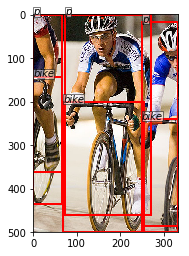

In [5]:
from PascalVOCDataloader import PascalVOCDataloader, create_split_loaders
data_dir = '/datasets/ee285f-public/PascalVOC2012/'
dataset = PascalVOCDataloader(data_dir)
image, bboxes, labels = dataset[10]
vis_bbox(at.tonumpy(image),
         at.tonumpy(bboxes),
         at.tonumpy(labels).reshape(-1))

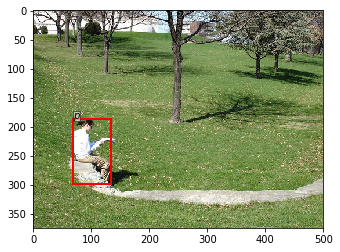

In [6]:
# Setup the training, validation, and testing dataloaders
train_loader, val_loader, test_loader = create_split_loaders(data_dir,batch_size=1)
image, bboxes, labels = next(iter(train_loader))
vis_bbox(at.tonumpy(image[0]),
         at.tonumpy(bboxes[0]),
         at.tonumpy(labels[0]).reshape(-1))

In [7]:
# Begin training loop
import numpy as np
import pandas as pd
num_epochs = 100
scale = 1
epoch_start = 0
loss_col = ['rpn_loc_loss',
            'rpn_cls_loss',
            'roi_loc_loss',
            'roi_cls_loss',
            'total_loss'
            ]
path = 'checkpoints/RCNN_Scratch'
if os.path.isfile(path+'.pth'):
    train_loss_prev, val_loss_prev = trainer.load(path)
    print(train_loss_prev)
    print(val_loss_prev)
    n_prev_epoch =  train_loss_prev.shape[0]
    epoch_start = n_prev_epoch 

print('Epoch Range: ',epoch_start,num_epochs)
for epoch in range(epoch_start,num_epochs):
    train_loss = pd.DataFrame(columns=loss_col)
    val_loss = pd.DataFrame(columns=loss_col)
    # Get the next minibatch of images, labels for training
    n_minibatch = len(train_loader)
    ave_loss = np.zeros((n_minibatch, 5))
    for minibatch, (images, bboxes, labels) in enumerate(train_loader, 0):
        images = images.cuda()
        try:
            loss = trainer.train_step(images, bboxes, labels, scale)
            loss = np.asarray([loss[i].item() for i in range(5)])
        except AssertionError: 
            loss = np.zeros((5))
            n_minibatch -= 1
            continue
        ave_loss[minibatch] = loss
    AVG = np.sum(ave_loss/n_minibatch, axis=0)
    tmp_df_train = pd.DataFrame([[AVG[i] for i in range(5)]], columns=loss_col)
    train_loss = train_loss.append(tmp_df_train, ignore_index=True)
    
    # Validation loss
    n_minibatch = len(val_loader)
    ave_loss = np.zeros((n_minibatch, 5))
    for minibatch, (images, bboxes, labels) in enumerate(val_loader, 0):
        images = images.cuda()
        try:
            loss = trainer.forward(images, bboxes, labels, scale)
            loss = np.asarray([loss[i].item() for i in range(5)])
        except AssertionError: 
            loss = np.zeros((5))
            n_minibatch -= 1
            continue
        ave_loss[minibatch] = loss
    AVG = np.sum(ave_loss/n_minibatch, axis=0)
    tmp_df_val = pd.DataFrame([[AVG[i] for i in range(5)]], columns=loss_col)
    val_loss = val_loss.append(tmp_df_val, ignore_index=True)
    
    print('Epoch ', epoch)
    print('train loss: ', tmp_df_train)
    print('val loss: ', tmp_df_val)
    trainer.save(train_loss, val_loss, save_optimizer=False, save_path=path)
        


Epoch Range:  0 100
Epoch  0
train loss:     rpn_loc_loss  rpn_cls_loss  roi_loc_loss  roi_cls_loss  total_loss
0      0.099296        0.1981       0.28418      0.297291    0.878866
val loss:     rpn_loc_loss  rpn_cls_loss  roi_loc_loss  roi_cls_loss  total_loss
0      0.083671      0.181648      0.252324       0.27582    0.793462
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/opt/conda/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chun

Epoch  1
train loss:     rpn_loc_loss  rpn_cls_loss  roi_loc_loss  roi_cls_loss  total_loss
0      0.081637      0.163349       0.23007      0.222446    0.697501
val loss:     rpn_loc_loss  rpn_cls_loss  roi_loc_loss  roi_cls_loss  total_loss
0      0.084121      0.169394      0.218806       0.22908    0.701401
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/opt/conda/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chun

Epoch  2
train loss:     rpn_loc_loss  rpn_cls_loss  roi_loc_loss  roi_cls_loss  total_loss
0      0.076016      0.146942       0.20741      0.195016    0.625384
val loss:     rpn_loc_loss  rpn_cls_loss  roi_loc_loss  roi_cls_loss  total_loss
0       0.07469      0.155105      0.202826      0.216429     0.64905
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/opt/conda/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chun

Epoch  3
train loss:     rpn_loc_loss  rpn_cls_loss  roi_loc_loss  roi_cls_loss  total_loss
0      0.072091      0.134564      0.187361      0.175355     0.56937
val loss:     rpn_loc_loss  rpn_cls_loss  roi_loc_loss  roi_cls_loss  total_loss
0      0.073725       0.16121      0.199205      0.215985    0.650126
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/opt/conda/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chun

Epoch  4
train loss:     rpn_loc_loss  rpn_cls_loss  roi_loc_loss  roi_cls_loss  total_loss
0      0.068989      0.123385      0.175755      0.164087    0.532216
val loss:     rpn_loc_loss  rpn_cls_loss  roi_loc_loss  roi_cls_loss  total_loss
0      0.074974      0.171056      0.200267      0.219325    0.665623
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/opt/conda/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chun

Epoch  5
train loss:     rpn_loc_loss  rpn_cls_loss  roi_loc_loss  roi_cls_loss  total_loss
0      0.066781      0.113767      0.163402      0.154485    0.498436
val loss:     rpn_loc_loss  rpn_cls_loss  roi_loc_loss  roi_cls_loss  total_loss
0      0.070456      0.161362      0.196865      0.212765    0.641449
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/opt/conda/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chun

Epoch  6
train loss:     rpn_loc_loss  rpn_cls_loss  roi_loc_loss  roi_cls_loss  total_loss
0      0.064402      0.106105      0.155066      0.146972    0.472545
val loss:     rpn_loc_loss  rpn_cls_loss  roi_loc_loss  roi_cls_loss  total_loss
0      0.070452      0.162633      0.186283      0.201308    0.620675
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/opt/conda/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chun

Epoch  7
train loss:     rpn_loc_loss  rpn_cls_loss  roi_loc_loss  roi_cls_loss  total_loss
0      0.062743      0.099981      0.147747      0.140074    0.450544
val loss:     rpn_loc_loss  rpn_cls_loss  roi_loc_loss  roi_cls_loss  total_loss
0      0.072152       0.16474      0.184109      0.205876    0.626877
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/opt/conda/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chun

Epoch  8
train loss:     rpn_loc_loss  rpn_cls_loss  roi_loc_loss  roi_cls_loss  total_loss
0      0.061219      0.093595       0.14104      0.134098    0.429952
val loss:     rpn_loc_loss  rpn_cls_loss  roi_loc_loss  roi_cls_loss  total_loss
0      0.071227      0.170541      0.175262      0.213073    0.630103
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/opt/conda/lib/python3.6/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/opt/conda/lib/python3.6/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/opt/conda/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chun

KeyboardInterrupt: 

In [ ]:
'''label_map = { 'unlabeled':0,'bicycle':1,'bottle':2,'bus':3,
                        'car':4, 'cat':5,'cow':6,'dog':7,
                        'horse':8, 'motorbike':9,'person':10,
                        'sheep':11, 'train':12}
label_reverse_map = {}
for key in label_map:
    label_reverse_map[label_map[key]]=key
print(label_reverse_map)
import numpy as np

# Save
np.save('label_map.npy', label_map)
np.save('label_reverse_map.npy', label_reverse_map)
read_dictionary = np.load('label_map.npy').item()
print(read_dictionary)
read_dictionary = np.load('label_reverse_map.npy').item()
print(read_dictionary)'''

In [ ]:
img, q, e = next(iter(test_loader))

bboxes, labels, scores = trainer.faster_rcnn.predict(img,visualize=True)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(bboxes[0]),
         at.tonumpy(labels[0]).reshape(-1),
         at.tonumpy(scores[0]).reshape(-1))